In [5]:
# Idea Dune Dweller (Kaggle)

In [6]:
import os.path
import datetime

import numpy  as np
import pandas as pd

In [42]:
# Variables: dirs and files

dirBase   = '..'

dirData   = os.path.join(dirBase,'Data')
dirPicle  = os.path.join(dirBase,'Data','Pickle')
dirTemp   = os.path.join(dirBase,'Temp','Temp')
dirResult = os.path.join(dirBase,'Result','Leak')

fileTrain      = os.path.join(dirData,'trainExt.csv')
fileValidation = os.path.join(dirData,'trainExtMin.csv')
fileTest       = os.path.join(dirData,'testExt.csv')

In [15]:
# Constants

chunkSize = 6000000
nClusters = 100
nTop      = 5


In [162]:
# Reader for test data (chunks) on one time
print(datetime.datetime.now(),'Read train datas ')
'''
OK =    os.path.exists(os.path.join(dirTemp,'rule1Test0Empty.pkl')) and \
        os.path.exists(os.path.join(dirTemp,'rule2Test0Empty.pkl')) and \
        os.path.exists(os.path.join(dirTemp,'rule3Test0Empty.pkl')) and \
        os.path.exists(os.path.join(dirTemp,'rule4Test0Empty.pkl')) and \
        os.path.exists(os.path.join(dirTemp,'rule1Test1Empty.pkl.npy')) and \
        os.path.exists(os.path.join(dirTemp,'rule2Test1Empty.pkl.npy')) and \
        os.path.exists(os.path.join(dirTemp,'rule3Test1Empty.pkl.npy')) and \
        os.path.exists(os.path.join(dirTemp,'rule4Test1Empty.pkl.npy'))
'''

OK = False 

if not OK :

    readerTest = pd.read_csv(fileTrain,chunksize=chunkSize,usecols=['srch_destination_id','is_booking','hotel_cluster'],dtype=int);
    ichunk = 0; aggs = [];
    for chunk in readerTest :
        ichunk += 1; print(datetime.datetime.now(),'chunk :',ichunk,chunk.shape)
        #if ichunk>1 : break
        agg = chunk.groupby(['srch_destination_id','hotel_cluster'])['is_booking'].agg(['sum','count'])
        agg.reset_index(inplace=True)
        aggs.append(agg)
        
    del chunk
    del readerTest
    
    aggs = pd.concat(aggs,axis=0)
    aggs.head()
    
    CLICK_WEIGHT = 1.0/30.0  #20.0 ==> 0.30349 #17.3 => 0.30347
    agg = aggs.groupby(['srch_destination_id','hotel_cluster']).sum().reset_index()
    agg['count'] -= agg['sum']
    agg = agg.rename(columns={'sum':'bookings','count':'clicks'})
    agg['relevance'] = agg['bookings'] + CLICK_WEIGHT * agg['clicks']
    print(agg.head())
    
    
    
    #rule1Test[0].count().reset_index().to_pickle(os.path.join(dirTemp,'rule1Test0Empty.pkl'))

print(datetime.datetime.now(),'Done ')

2016-06-01 05:47:26.116521 Read train datas 
2016-06-01 05:47:34.529878 chunk : 1 (6000000, 3)
2016-06-01 05:47:44.283917 chunk : 2 (6000000, 3)
2016-06-01 05:47:54.140044 chunk : 3 (6000000, 3)
2016-06-01 05:48:03.867322 chunk : 4 (6000000, 3)
2016-06-01 05:48:13.652393 chunk : 5 (6000000, 3)
2016-06-01 05:48:29.487149 chunk : 6 (6000000, 3)
2016-06-01 05:48:33.756239 chunk : 7 (1670293, 3)
   srch_destination_id  hotel_cluster  bookings  clicks  relevance
0                    0              3         0       2   0.066667
1                    1             20         4      22   4.733333
2                    1             30         2      20   2.666667
3                    1             57         0       1   0.033333
4                    1             60         0      17   0.566667
2016-06-01 05:48:34.817471 Done 


In [163]:
most_pop_all = agg.groupby('hotel_cluster')['relevance'].sum().nlargest(5).index
#most_pop_all = np.array_str(most_pop_all)[1:-1]
most_pop_all

Int64Index([91, 48, 42, 59, 28], dtype='int64', name='hotel_cluster')

In [164]:
def most_popular(group, n_max=5):
    relevance = group['relevance'].values
    hotel_cluster = group['hotel_cluster'].values
    most_popular = hotel_cluster[np.argsort(relevance)[::-1]][:n_max]
    if (len(most_popular)<5) : 
        #print(most_popular)
        mp=most_popular.tolist()+most_pop_all.values.tolist()
        most_popular = np.array(mp)
        #print(mp,most_popular)
    most_popular = most_popular[:n_max]
    return np.array_str(most_popular)[1:-1] # remove square brackets

In [165]:
print(datetime.datetime.now(),'Build decision')
most_pop = agg.groupby(['srch_destination_id']).apply(most_popular)
most_pop = pd.DataFrame(most_pop).rename(columns={0:'hotel_cluster'})
print(datetime.datetime.now(),'Done ')
most_pop.head()

2016-06-01 05:48:52.195334 Build decision
2016-06-01 05:49:18.905894 Done 


,hotel_cluster
srch_destination_id,
0,3 91 48 42 59
1,20 30 60 57 91
2,20 30 53 46 41
3,53 60 91 48 42
4,82 25 32 58 78


In [166]:
test = pd.read_csv(fileTest,dtype={'srch_destination_id':np.int32},usecols=['srch_destination_id'],)

In [167]:
test = test.merge(most_pop, how='left',left_on='srch_destination_id',right_index=True)
test.head()

,srch_destination_id,hotel_cluster
0,12243,55 5 37 11 22
1,14474,5 91 48 42 59
2,11353,0 31 77 91 96
3,8250,1 45 79 24 54
4,11812,91 42 2 59 48


In [168]:
test.hotel_cluster.isnull().sum()

14036

In [169]:
most_pop_all = agg.groupby('hotel_cluster')['relevance'].sum().nlargest(5).index
most_pop_all = np.array_str(most_pop_all)[1:-1]
most_pop_all

'91 48 42 59 28'

In [170]:
test.hotel_cluster.fillna(most_pop_all,inplace=True)

In [171]:
test.hotel_cluster.isnull().sum()

0

In [172]:
fileResult = os.path.join(dirResult,'df-Dweller-Leak-'+datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')+'.csv'); fileResult

'..\\Result\\Leak\\df-Dweller-Leak-2016-06-01-05-50-02.csv'

In [173]:
test.hotel_cluster.to_csv(fileResult,header=True, index_label='id')

In [174]:
'-'*80

'--------------------------------------------------------------------------------'

In [ ]:
# Validation on train(is_booking==1) datas

In [112]:
def groupXarr (rule,kkey) : 
    rr  = int(rule[0].get_group(kkey)[[-1]].iloc[0])
    rrr = pd.Series(rule[1][rr]).nlargest(nTop)
    rra = rrr.index.tolist()
    rrb = rrr.tolist()
    return(rra,rrb)


In [149]:
Validation = True
if Validation :        
    print(datetime.datetime.now(),'Validation')
    #readerTrain = pd.read_csv(fileValidation,chunksize=chunkSize);
    readerTrain = pd.read_csv(fileValidation,chunksize=100000);
    #readerTrain
    
    result = 0.0; resultl = []
    nEvent = 0;  
    ichunk = -1
    for chunk in readerTrain :
        ichunk += 1
        irow = -1;
        if (ichunk>3) : print(datetime.datetime.now(),'break'); break
        print(datetime.datetime.now(),'chunk :',ichunk,chunk.shape)
            
        ulc = chunk['user_location_city']
        odd = chunk['orig_destination_distance']
        sdi = chunk['srch_destination_id']
        hco = chunk['hotel_country']
        hma = chunk['hotel_market']
        hcl = chunk['hotel_cluster']
        
        for irow in range(chunk.shape[0]):
            if (irow>2500) : break;
            ra, rb  = [],[]
            nEvent += 1;
            xEvent  = 0;
            
            try :   xEvent+= 2; rra,rrb  = groupXarr(rule1Test,(ulc[irow],odd[irow]))
            except  KeyError : rra = []; rrb = []; xEvent-=2
            finally : 
                ra = rra; rb = rrb; rr = [rra,rrb]
                
            try :   xEvent+= 4; rra,rrb  = groupXarr(rule2Test,(sdi[irow],hco[irow],hma[irow]))
            except  KeyError : rra = []; rrb = []; xEvent-=4
            finally :
                rb = rb + [rrb[i] for i in range(len(rrb)) if rra[i] not in ra]
                ra = ra + [i      for i in rra             if i      not in ra]
                rr.append([rra,rrb])
                
            try :   xEvent+= 8; rra,rrb  = groupXarr(rule3Test,(sdi[irow]))
            except  KeyError : rra = []; rrb = []; xEvent-=8
            finally :
                rb = rb + [rrb[i] for i in range(len(rrb)) if rra[i] not in ra]
                ra = ra + [i      for i in rra             if i      not in ra]
                rr.append([rra,rrb])
                
            try :   xEvent+=16; rra,rrb  = groupXarr(rule4Test,(hco[irow]))
            except  KeyError : rra = []; rrb = []; xEvent-=16
            finally :
                rb = rb + [rrb[i] for i in range(len(rrb)) if rra[i] not in ra]
                ra = ra + [i      for i in rra             if i      not in ra]
                rr.append([rra,rrb])
                
            res5 = ra[0:nTop]; res = 0.0
            if hcl[irow] in res5 : res = 1/(res5.index(hcl[irow])+1)
            result += res
            resultl.append([res,xEvent])
            
            
            #if (nEvent%10000==0) : print(ichunk,irow,result,result/nEvent,hcl[irow],res5) #,ra,rb)
                
    print('----> result = ',result,result/nEvent)
    print(datetime.datetime.now(),'Done')
            
            



2016-06-01 03:22:04.247007 Validation
2016-06-01 03:22:04.655998 chunk : 0 (100000, 36)
2016-06-01 03:22:18.106760 chunk : 1 (100000, 36)
2016-06-01 03:22:29.767320 chunk : 2 (100000, 36)
2016-06-01 03:22:41.516804 chunk : 3 (100000, 36)
2016-06-01 03:22:53.438712 break
----> result =  3592.716666666672 0.359128015460483
2016-06-01 03:22:53.438712 Done


<IPython.core.display.Javascript object>


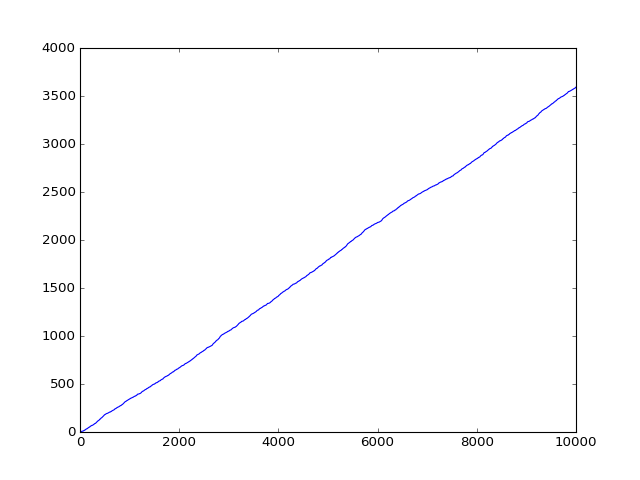

In [150]:
resultl
import matplotlib
from matplotlib import pyplot as plt
%matplotlib notebook
res=pd.DataFrame(resultl); res.columns=['result','who']; res['cumres']=res['result'].cumsum()
#res['who'].hist()
#res['result'].hist()
res['cumres'].plot()

